### DOMAIN: 
Automotive Surveillance

### CONTEXT:
Computer  vision  can  be  used  to  automate  supervision  and  generate  action  appropriate  action  trigger  if  the  event  is predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of the car, type, colour, number plates etc.

### DATA DESCRIPTION:
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

#### Train Images: 
Consists of real images of cars as per the make and year of the car. ‣Test Images: Consists of real images of cars as per the make and year of the car.
#### Train Annotation:
Consists of bounding box region for training images.
#### Test Annotation:
Consists of bounding box region for testing images.

## Import Required Python Library

In [61]:
import os
import zipfile
import glob # for file path handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #for visualization
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image # For image loading and manipulation
import xml.etree.ElementTree as ET # For handling XML annotations (common for object detection datasets)

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50



In [22]:
# Define file paths
car_names_file = 'B:/AIML/Project/Capstone Project/Car names and make.csv'
annotations_zip_file = 'B:/AIML/Project/Capstone Project/Annotations.zip'
images_zip_file = 'B:/AIML/Project/Capstone Project/Car Images.zip'

# Step 1: Load the car names and make data
car_names_df = pd.read_csv(car_names_file)

# Display the first few rows of the DataFrame
print("Car Names and Makes:")
print(car_names_df.head())

# Step 2: Extract Annotations.zip
with zipfile.ZipFile(annotations_zip_file, 'r') as zip_ref:
    zip_ref.extractall('Annotations')

# List the extracted files
print("\nExtracted Annotations:")
print(os.listdir('Annotations'))

# Step 3: Extract Car Images.zip
with zipfile.ZipFile(images_zip_file, 'r') as zip_ref:
    zip_ref.extractall('Car Images')

# List the extracted files
print("\nExtracted Car Images:")
print(os.listdir('Car Images'))

Car Names and Makes:
  AM General Hummer SUV 2000
0        Acura RL Sedan 2012
1        Acura TL Sedan 2012
2       Acura TL Type-S 2008
3       Acura TSX Sedan 2012
4  Acura Integra Type R 2001

Extracted Annotations:
['Annotations']

Extracted Car Images:
['Car Images']


In [26]:
#Load the training annotations
train_annotations_path = 'B:/AIML/Project/Capstone Project/Annotations/Train Annotations.csv'  # Adjust the path as necessary
train_annotations_df = pd.read_csv(train_annotations_path)
print("Training Annotations Columns:")
print(train_annotations_df.columns)
train_annotations_df.head(5)

Training Annotations Columns:
Index(['Image Name', 'Bounding Box coordinates_xmin',
       'Bounding Box coordinates_ymin', 'Bounding Box coordinates_xmax',
       'Bounding Box coordinates_ymax', 'Image class'],
      dtype='object')


Image Name  Bounding Box coordinates_xmin  Bounding Box coordinates_ymin  \
0  00001.jpg                             39                            116   
1  00002.jpg                             36                            116   
2  00003.jpg                             85                            109   
3  00004.jpg                            621                            393   
4  00005.jpg                             14                             36   

   Bounding Box coordinates_xmax  Bounding Box coordinates_ymax  Image class  
0                            569                            375           14  
1                            868                            587            3  
2                            601                            381           91  
3                           1484                           1096          134  
4                            133                             99          106

In [27]:
# Load the Test annotations
test_annotations_path = 'B:/AIML/Project/Capstone Project/Annotations/Test Annotation.csv'  # Adjust the path as necessary
test_annotations_df = pd.read_csv(test_annotations_path)
print("Test Annotations Columns:")
print(test_annotations_df.columns)
test_annotations_df.head(5)

Test Annotations Columns:
Index(['Image Name', 'Bounding Box coordinates_xmin',
       'Bounding Box coordinates_ymin', 'Bounding Box coordinates_xmax',
       'Bounding Box coordinates_ymax', 'Image class'],
      dtype='object')


Image Name  Bounding Box coordinates_xmin  Bounding Box coordinates_ymin  \
0  00001.jpg                             30                             52   
1  00002.jpg                            100                             19   
2  00003.jpg                             51                            105   
3  00004.jpg                             67                             84   
4  00005.jpg                            140                            151   

   Bounding Box coordinates_xmax  Bounding Box coordinates_ymax  Image class  
0                            246                            147          181  
1                            576                            203          103  
2                            968                            659          145  
3                            581                            407          187  
4                            593                            339          185

In [28]:
# Renaming column names
train_annotations_df = train_annotations_df.rename(columns={'Bounding Box coordinates':'Bounding Box coordinates_xmin','Unnamed: 2':'Bounding Box coordinates_ymin','Unnamed: 3':'Bounding Box coordinates_xmax','Unnamed: 4':'Bounding Box coordinates_ymax'})
train_annotations_df.head(5)

Image Name  Bounding Box coordinates_xmin  Bounding Box coordinates_ymin  \
0  00001.jpg                             39                            116   
1  00002.jpg                             36                            116   
2  00003.jpg                             85                            109   
3  00004.jpg                            621                            393   
4  00005.jpg                             14                             36   

   Bounding Box coordinates_xmax  Bounding Box coordinates_ymax  Image class  
0                            569                            375           14  
1                            868                            587            3  
2                            601                            381           91  
3                           1484                           1096          134  
4                            133                             99          106

In [29]:
# Renaming column names
test_annotations_df = test_annotations_df.rename(columns={'Bounding Box coordinates':'Bounding Box coordinates_xmin','Unnamed: 2':'Bounding Box coordinates_ymin','Unnamed: 3':'Bounding Box coordinates_xmax','Unnamed: 4':'Bounding Box coordinates_ymax'})
test_annotations_df.head(5)

Image Name  Bounding Box coordinates_xmin  Bounding Box coordinates_ymin  \
0  00001.jpg                             30                             52   
1  00002.jpg                            100                             19   
2  00003.jpg                             51                            105   
3  00004.jpg                             67                             84   
4  00005.jpg                            140                            151   

   Bounding Box coordinates_xmax  Bounding Box coordinates_ymax  Image class  
0                            246                            147          181  
1                            576                            203          103  
2                            968                            659          145  
3                            581                            407          187  
4                            593                            339          185

In [36]:
# for images
train_images_path = os.path.join('B:/AIML/Project/Capstone Project/Car Images/Car Images/Train Images')
test_images_path = os.path.join('B:/AIML/Project/Capstone Project/Car Images/Car Images/Test Images')

In [37]:
train_class_folders = [f.path for f in os.scandir(train_images_path) if f.is_dir()]

train_image_classes = {} # Dictionary to store training image: class mapping

# Define columns for the Training DataFrame
columns_training = ['Image_Path', 'labels']

# Create an empty DataFrame
df_training = pd.DataFrame(columns=columns_training)

# --- Map filenames in a class for train_image_classes
for class_folder in train_class_folders:
     class_name = os.path.basename(class_folder) # Extract class name from folder name
     #labels_train.append(class_name)
     image_files = glob.glob(os.path.join(class_folder, '*.jpg')) # images are .jpg
     for image_file in image_files:
         train_image_classes[os.path.basename(image_file)] = class_name # Map filename to class
         #image_file_path_training.append(image_file)
         df_training.loc[len(df_training)] = [image_file, class_name]


print(df_training.head(10))

# --- Print a few mappings to verify ---
print("Sample Training Image to Class Mappings:")
count = 0
for img_name, class_label in train_image_classes.items():
    print(f"{img_name}: {class_label}")
    count += 1
    if count > 5: break # Print first few only



                                          Image_Path  \
0  B:/AIML/Project/Capstone Project/Car Images/Ca...   
1  B:/AIML/Project/Capstone Project/Car Images/Ca...   
2  B:/AIML/Project/Capstone Project/Car Images/Ca...   
3  B:/AIML/Project/Capstone Project/Car Images/Ca...   
4  B:/AIML/Project/Capstone Project/Car Images/Ca...   
5  B:/AIML/Project/Capstone Project/Car Images/Ca...   
6  B:/AIML/Project/Capstone Project/Car Images/Ca...   
7  B:/AIML/Project/Capstone Project/Car Images/Ca...   
8  B:/AIML/Project/Capstone Project/Car Images/Ca...   
9  B:/AIML/Project/Capstone Project/Car Images/Ca...   

                      labels  
0  Acura Integra Type R 2001  
1  Acura Integra Type R 2001  
2  Acura Integra Type R 2001  
3  Acura Integra Type R 2001  
4  Acura Integra Type R 2001  
5  Acura Integra Type R 2001  
6  Acura Integra Type R 2001  
7  Acura Integra Type R 2001  
8  Acura Integra Type R 2001  
9  Acura Integra Type R 2001  
Sample Training Image to Class Mappings:
0

In [38]:
test_class_folders = [f.path for f in os.scandir(test_images_path) if f.is_dir()]
test_image_classes = {}  # Dictionary to store testing image: class mapping

# Define columns for the Testing DataFrame
columns_testing = ['Image_Path', 'labels']

# Create an empty DataFrame
df_testing = pd.DataFrame(columns=columns_testing)

# similar logic for test_images_path and test_image_classes
for class_folder in test_class_folders:
     class_name = os.path.basename(class_folder) # Extract class name from folder name
     #labels_testing.append(class_name)
     image_files = glob.glob(os.path.join(class_folder, '*.jpg')) # images are .jpg
     for image_file in image_files:
         test_image_classes[os.path.basename(image_file)] = class_name # Map filename to class
         #image_file_path_testing.append(image_file)
         df_testing.loc[len(df_testing)] = [image_file, class_name]

print(df_testing.head(10))

print("Sample Testing Image to Class Mappings:")
count = 0
for img_name, class_label in test_image_classes.items():
    print(f"{img_name}: {class_label}")
    count += 1
    if count > 5: break # Print first few only



                                          Image_Path  \
0  B:/AIML/Project/Capstone Project/Car Images/Ca...   
1  B:/AIML/Project/Capstone Project/Car Images/Ca...   
2  B:/AIML/Project/Capstone Project/Car Images/Ca...   
3  B:/AIML/Project/Capstone Project/Car Images/Ca...   
4  B:/AIML/Project/Capstone Project/Car Images/Ca...   
5  B:/AIML/Project/Capstone Project/Car Images/Ca...   
6  B:/AIML/Project/Capstone Project/Car Images/Ca...   
7  B:/AIML/Project/Capstone Project/Car Images/Ca...   
8  B:/AIML/Project/Capstone Project/Car Images/Ca...   
9  B:/AIML/Project/Capstone Project/Car Images/Ca...   

                      labels  
0  Acura Integra Type R 2001  
1  Acura Integra Type R 2001  
2  Acura Integra Type R 2001  
3  Acura Integra Type R 2001  
4  Acura Integra Type R 2001  
5  Acura Integra Type R 2001  
6  Acura Integra Type R 2001  
7  Acura Integra Type R 2001  
8  Acura Integra Type R 2001  
9  Acura Integra Type R 2001  
Sample Testing Image to Class Mappings:
00

In [40]:

# ********Definition of the method ********************************
def map_images_to_bboxes(annotations_file):
    image_bboxes = {}
    try:
        for index, row in annotations_file.iterrows():
                image_name = row['Image Name']
                x_min = row['Bounding Box coordinates_xmin']
                y_min = row['Bounding Box coordinates_ymin']
                x_max = row['Bounding Box coordinates_xmax']
                y_max = row['Bounding Box coordinates_ymax']
                image_class = row['Image class']

                image_bboxes[image_name] = (x_min, y_min, x_max, y_max) # Store bbox as tuple

    except FileNotFoundError:
        print(f"Error: Annotation file not found: {annotations_file}")
    except KeyError as e:
        print(f"Error: Column '{e}' not found in CSV file. Check your CSV column names.")
        print("Expected columns (example): filename, xmin, ymin, xmax, ymax") # Example expected columns

    return image_bboxes



In [41]:
train_image_bboxes = map_images_to_bboxes(train_annotations_df)
# --- Print a few mappings to verify for Training images ---
print("\nSample Training Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in train_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break




Sample Training Image to Bounding Box Mappings (DF):
00001.jpg: (39, 116, 569, 375)
00002.jpg: (36, 116, 868, 587)
00003.jpg: (85, 109, 601, 381)
00004.jpg: (621, 393, 1484, 1096)
00005.jpg: (14, 36, 133, 99)
00006.jpg: (259, 289, 515, 416)


In [42]:
test_image_bboxes = map_images_to_bboxes(test_annotations_df)
# --- Print a few mappings to verify  testing images---
print("\nSample Testing Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in test_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break


Sample Testing Image to Bounding Box Mappings (DF):
00001.jpg: (30, 52, 246, 147)
00002.jpg: (100, 19, 576, 203)
00003.jpg: (51, 105, 968, 659)
00004.jpg: (67, 84, 581, 407)
00005.jpg: (140, 151, 593, 339)
00006.jpg: (20, 77, 420, 301)


In [43]:
# Display images with bounding boxes
def display_image_with_bbox(image_path, annotation):
    # Load image
    img = Image.open(image_path)

    # Create plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding box
    x_min = row['Bounding Box coordinates_xmin']
    y_min = row['Bounding Box coordinates_ymin']
    x_max = row['Bounding Box coordinates_xmax']
    y_max = row['Bounding Box coordinates_ymax']
    image_class = row['Image class']
    bbox = annotation['bbox']
    rect = patches.Rectangle(
        (x_min, y_min),  # (x_min, y_min) -  (bbox[0], bbox[1])
        (x_max - x_min),   # width (x_max - x_min)  - bbox[2] - bbox[0]
        (y_max - y_min),   # height (y_max - y_min) -- bbox[3] - bbox[1]
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

    # Add class label
    plt.text(
        bbox[0], bbox[1] - 10,  # Position of the label
        annotation['image_class'],
        color='red',
        fontsize=12,
        backgroundcolor='white'
    )

    plt.axis('off')
    plt.show()




For Training Images


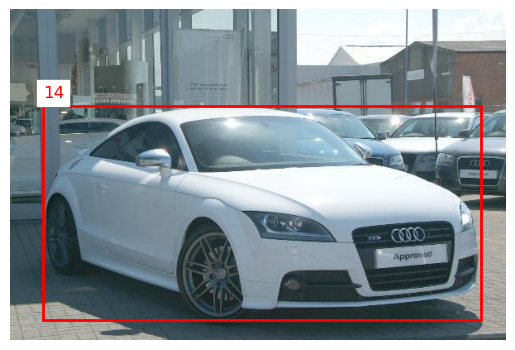

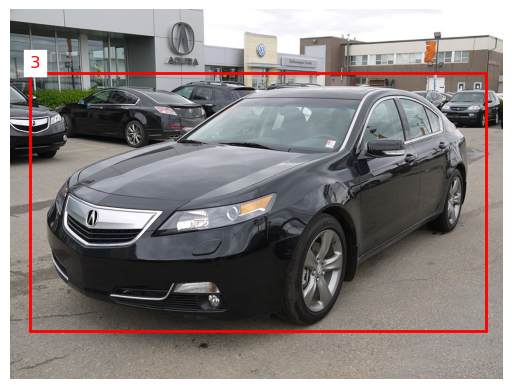

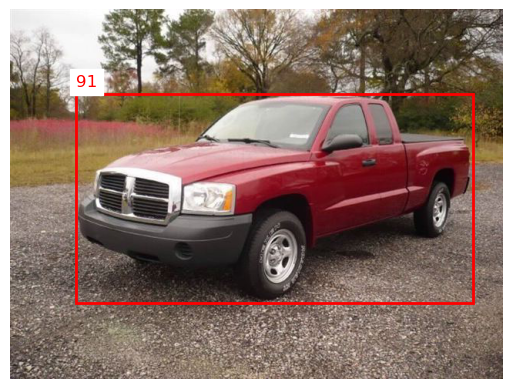

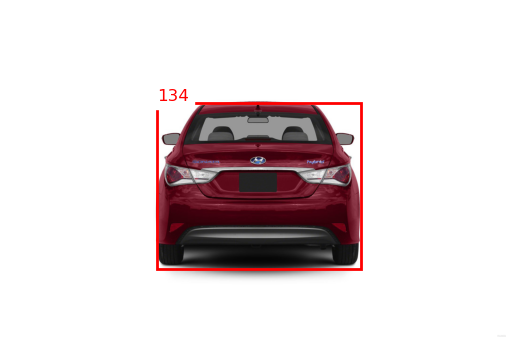

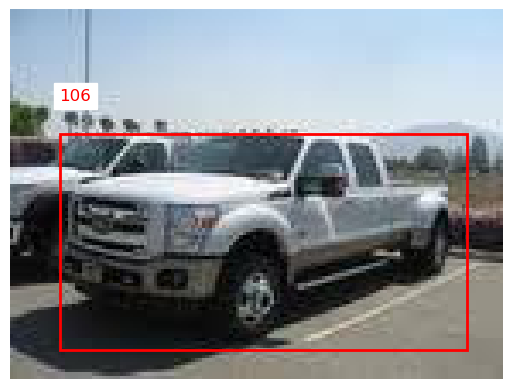

Displayed 5 training images with bounding boxes.


In [44]:
# for training images
print("For Training Images") # Changed message to "Test Image"
displayed_image_count = 0  # Initialize a counter to track displayed images

image_paths_details_training=[]
images_paths_details_testing=[]

for index, row in train_annotations_df.iterrows():
    if displayed_image_count >= 5: # Check if we've already displayed two images
        break  # If yes, exit the loop

    image_name = str(row['Image Name']).strip()
    image_path = None # Initialize image_path to None


    for class_folder in train_class_folders:
        potential_image_path = os.path.join(class_folder, image_name)
        if os.path.exists(potential_image_path):
            image_path = potential_image_path
            image_paths_details_training.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path: # If image_path is found (not None)
        annotation = {
            'bbox': [row['Bounding Box coordinates_xmin'], row['Bounding Box coordinates_ymin'], row['Bounding Box coordinates_xmax'], row['Bounding Box coordinates_ymax']],
            'image_class' : row['Image class']
        }
        display_image_with_bbox(image_path, annotation)
        displayed_image_count += 1 # Increment the counter
    #else:
    #    print(f"Training Image not found: {image_name}")

print(f"Displayed {displayed_image_count} training images with bounding boxes.")

For Testing Images


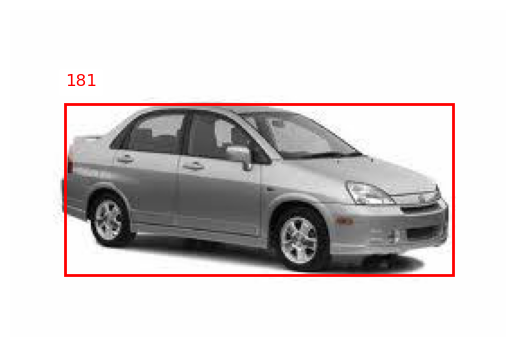

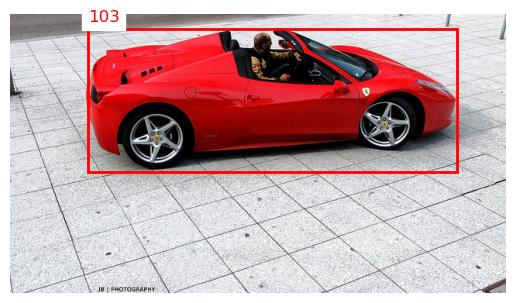

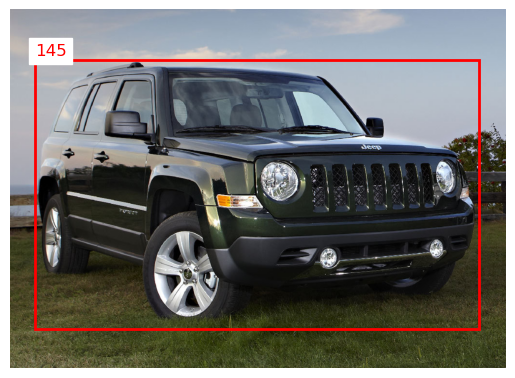

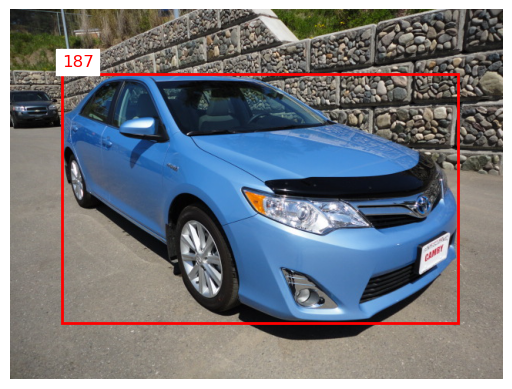

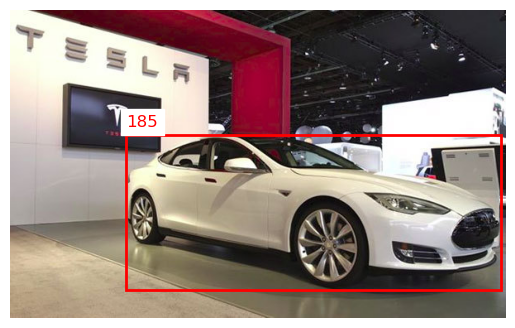

Displayed 5 test images with bounding boxes.


In [45]:

# for test images
print("For Testing Images") # Changed message to "Test Image"
displayed_image_count_test = 0  # Initialize a counter to track displayed images

for index, row in test_annotations_df.iterrows():  # Use test_annotations_df DataFrame
    if displayed_image_count_test >= 5: # Check if we've already displayed two images (adjust number here if you want 5 or more)
        break  # If yes, exit the loop

    image_name_test = str(row['Image Name']).strip()
    image_path_test = None # Initialize image_path_test to None

    for class_folder in test_class_folders: # Use test_class_folders
        potential_image_path_test = os.path.join(class_folder, image_name_test)
        if os.path.exists(potential_image_path_test):
            image_path_test = potential_image_path_test # Assigned to image_path_test
            images_paths_details_testing.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path_test: # If image_path_test is found (not None)
        annotation_test = {
            'bbox': [row['Bounding Box coordinates_xmin'], row['Bounding Box coordinates_ymin'], row['Bounding Box coordinates_xmax'], row['Bounding Box coordinates_ymax']],
            'image_class' : row['Image class'] # Assuming 'Image class' column also exists in test_annotations_df (verify!)
        }
        display_image_with_bbox(image_path_test, annotation_test)  # Changed here
        displayed_image_count_test += 1 # Increment the counter
    #else:
    #    print(f"Test Image not found: {image_name_test}") # Changed message to "Test Image"

print(f"Displayed {displayed_image_count_test} test images with bounding boxes.") # Changed message to "test images"




In [46]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image for CNN input.
    """
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Warning: Image file not found: {image_path}")
        return None  # Or handle the missing image in a way that makes sense for your application

    image = cv2.imread(image_path)  # Load image

    # Check if image loading was successful
    if image is None:
        print(f"Warning: Failed to load image: {image_path}")
        return None  # Or handle the loading error as needed

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

In [47]:
def custom_generator(df, batch_size, target_size):
    """
    Custom generator for images and labels.
    """
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = df.iloc[offset:offset + batch_size]
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image = preprocess_image(row['Image_Path'], target_size)
                label = row['label_categorical']
                images.append(image)
                labels.append(label)
            X = np.array(images)
            y = np.array(labels)
            yield X, y

In [48]:
# Apply preprocessing to all images
df_testing['image'] = df_testing['Image_Path'].apply(preprocess_image)
df_training['image'] = df_training['Image_Path'].apply(preprocess_image)

# Check for and handle None values in the 'image' column
df_testing = df_testing.dropna(subset=['image'])  # Remove rows with None in 'image'
df_training = df_training.dropna(subset=['image'])  # Remove rows with None in 'image'

In [56]:
# Encode labels
label_encoder = LabelEncoder()
df_testing['labels_encoded'] = label_encoder.fit_transform(df_testing['labels'])
df_training['labels_encoded'] = label_encoder.fit_transform(df_training['labels'])

# Convert labels to categorical (one-hot encoding)
df_testing['label_categorical'] = df_testing['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))
df_training['label_categorical'] = df_training['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))

In [57]:
# Split df_training into training and validation sets
df_train, df_val = train_test_split(df_training, test_size=0.2, random_state=42)

In [58]:
# Create generatorss
batch_size = 32
#train_generator = custom_generator(df_training, batch_size, target_size=(224, 224))
#val_generator = custom_generator(df_testing, batch_size, target_size=(224, 224))
# Create generators
batch_size = 32
train_generator = custom_generator(df_train, batch_size, target_size=(224, 224))
val_generator = custom_generator(df_val, batch_size, target_size=(224, 224))  # Use df_val for validation
# Test generator remains the same
test_generator = custom_generator(df_testing, batch_size, target_size=(224, 224))

In [59]:
# Check training generator
X_batch, y_batch = next(train_generator)
print("Training batch shape:", X_batch.shape, y_batch.shape)

# Check validation generator
X_batch, y_batch = next(val_generator)
print("Validation batch shape:", X_batch.shape, y_batch.shape)

Training batch shape: (32, 224, 224, 3) (32, 196)
Validation batch shape: (32, 224, 224, 3) (32, 196)


## ResNet

In [62]:
# Load ResNet50 base model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(df_training['labels_encoded'].unique()), activation='softmax')(x)  # Output layer

# Define model
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,737,348 (94.37 MB)

 Trainable params: 1,149,636 (4.39 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [63]:
epochs = 10
steps_per_epoch = len(df_train) // batch_size
validation_steps = len(df_val) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs
)

Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 919s 4s/step - accuracy: 0.0071 - loss: 5.5585 - val_accuracy: 0.0050 - val_loss: 5.2898
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 889s 4s/step - accuracy: 0.0068 - loss: 5.2961 - val_accuracy: 0.0056 - val_loss: 5.2857
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - accuracy: 0.0048 - loss: 5.2827 - val_accuracy: 0.0056 - val_loss: 5.2813
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 959s 5s/step - accuracy: 0.0073 - loss: 5.2757 - val_accuracy: 0.0044 - val_loss: 5.2794
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1014s 5s/step - accuracy: 0.0053 - loss: 5.2728 - val_accuracy: 0.0031 - val_loss: 5.2782
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 935s 5s/step - accuracy: 0.0069 - loss: 5.2687 - val_accuracy: 0.0050 - val_loss: 5.2783
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 927s 5s/step - accuracy: 0.0094 - loss: 5.2678 - val_accuracy: 0.0088 - val_loss: 5.2758
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 979s 5s/step - accuracy: 0.0106 - loss: 5.2651 - val_acc

In [ ]:
mport matplotlib.pyplot as plt

# Extract accuracy and loss
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(train_acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

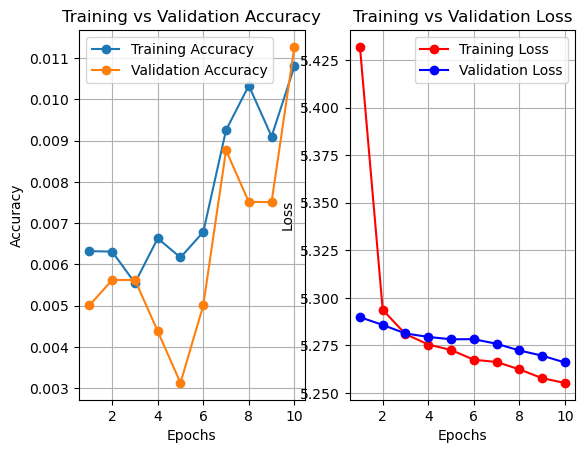

In [64]:
# Extract history data
resnet_train_loss = history.history['loss']
resnet_val_loss = history.history['val_loss']
resnet_train_acc = history.history['accuracy']
resnet_val_acc = history.history['val_accuracy']

epochs_range = range(1, len(resnet_train_loss) + 1)  # Number of epochs
# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, resnet_train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, resnet_val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, resnet_train_loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, resnet_val_loss, label='Validation Loss', marker='o', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()

# Show the plots
plt.show()

In [65]:
# Define the number of validation steps
val_steps = len(df_val) // batch_size  # Ensures we process the entire validation set

# Initialize lists to store true labels and predictions
y_true = []
y_pred = []

# Loop over the validation generator to collect predictions and true labels
for _ in range(val_steps):
    X_batch, y_batch = next(val_generator)  # Get a batch from the generator
    y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot labels to class indices
    
    # Predict on the batch
    y_pred_probs = model.predict(X_batch)
    y_pred.extend(np.argmax(y_pred_probs, axis=1))  # Convert predicted probabilities to class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_,zero_division=1)
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

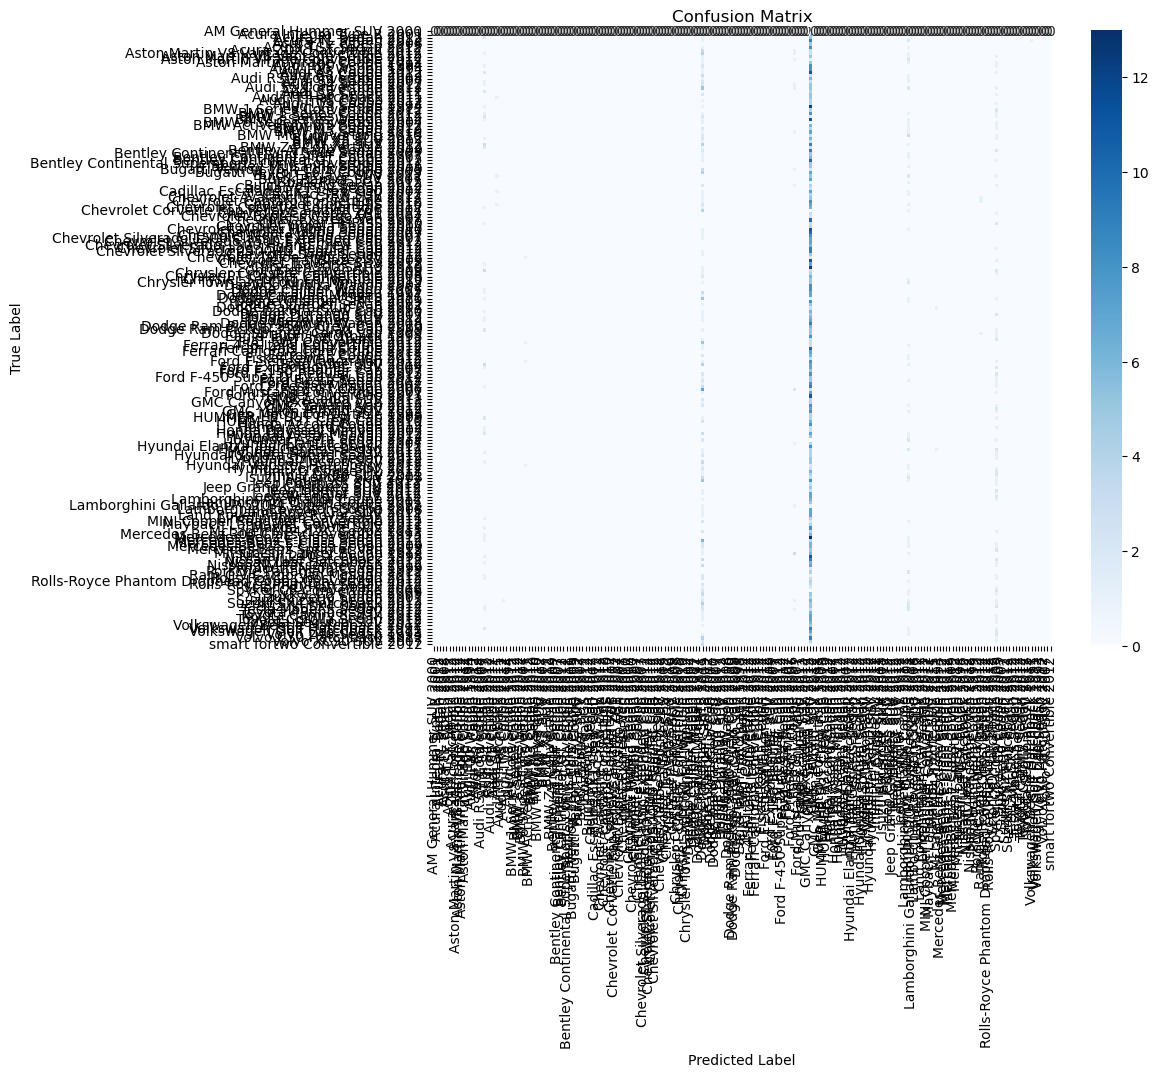

In [67]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Observation:

* The model is not doing well as expected
* exteremely low accuracy
* High Precision and Very low Recall

## Further Actions could be

* Check for Data Imbalance
* Fine tune parameters and retrain the model